In [1]:
import os
import pandas as  pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

## Dataset

In [2]:
class NUSW_NB15_Dataset(Dataset):
    def __init__(self, path, mode='all'):
        ds_type = path.split('/')[-1].split('-')[0]
        df = pd.read_csv(path)
        
        if mode == 'normal':
            # get only normal data
            df = df[df['label'] == 0]
        elif mode == 'anomaly':
            # get only anormal data
            df = df[df['label'] == 1]
        
        x = df.drop(['id', 'attack_cat', 'label'], axis=1)
        y = df['label']

        self.x = torch.Tensor(x.to_numpy())
        self.y = torch.Tensor(y.to_numpy())

        self.dim = self.x.shape[1]

        print(
            f'Finished reading the {ds_type} set ({mode}) of Dataset',
            f'({len(self.x)} samples found, each dim = {self.dim})'
        )

    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)
    

def prep_dataloader(path, batch_size, shuffle, mode='all'):
    dataset = NUSW_NB15_Dataset(path, mode)
    
    dataloader = DataLoader(
        dataset,
        batch_size,
        shuffle
    )

    return dataloader

## Neural Network

In [3]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(196, 64),
            nn.ELU(),
            nn.Linear(64, 16),
            nn.ELU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ELU(),
            nn.Linear(64, 196),
            nn.ELU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Trainer

In [4]:
def train(dataloader, model, loss_fn, optimizer, device):
    num_batches = len(dataloader)
    avg_loss = 0
    model.train()
    with tqdm(dataloader) as pbar:
        for (X, _) in pbar:
            X = X.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, X)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # sum loss and correct
            avg_loss += loss.item()

            # set loss val to pbar
            pbar.set_postfix(loss=f'{loss.item():>7f}')

    # cal avg loss and correct
    avg_loss /= num_batches
    print(f"[Train] Avg loss: {avg_loss:>8f} \n")
    return avg_loss


def test(dataloader, model, loss_fn, device):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, _ in dataloader:
            X = X.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, X).item()
    test_loss /= num_batches
    print(f"[Test] Avg loss: {test_loss:>8f} \n")
    return test_loss

## Training & Testing

### Set Config

In [5]:
# config
# path
tr_path = '../../data/anomaly_detection/training-set.csv'
val_path = '../../data/anomaly_detection/validation-set.csv'
tt_path = '../../data/anomaly_detection/testing-set.csv'
log_path = '../../logs/anomaly_detection'
model_path = '../../models/anomaly_detection/AE_model_weights.pth'

# hyperparameter
epochs = 1000
batch_size = 64
lr = 1e-3

### Load Data

In [6]:
# prepare dataloader
normal_tr_dl = prep_dataloader(
    tr_path,
    batch_size,
    shuffle=True,
    mode='normal'
)

normal_val_dl = prep_dataloader(
    val_path,
    batch_size,
    shuffle=False,
    mode='normal'
)

normal_tt_dl = prep_dataloader(
    tt_path,
    batch_size,
    shuffle=False,
    mode='normal'
)

all_tr_dl = prep_dataloader(
    tr_path,
    batch_size,
    shuffle=False,
    mode='all'
)

all_val_dl = prep_dataloader(
    val_path,
    batch_size,
    shuffle=False,
    mode='all'
)

all_tt_dl = prep_dataloader(
    tt_path,
    batch_size,
    shuffle=False,
    mode='all'
)

Finished reading the training set (normal) of Dataset (59584 samples found, each dim = 196)
Finished reading the validation set (normal) of Dataset (14753 samples found, each dim = 196)
Finished reading the testing set (normal) of Dataset (18663 samples found, each dim = 196)
Finished reading the training set (all) of Dataset (164910 samples found, each dim = 196)
Finished reading the validation set (all) of Dataset (41228 samples found, each dim = 196)
Finished reading the testing set (all) of Dataset (51535 samples found, each dim = 196)


### Training 

In [7]:
def get_log_name(model, loss_fn, optimizer, epochs, batch_size, lr):
    m = model.__class__.__name__
    l_fn = loss_fn.__class__.__name__
    opt = optimizer.__class__.__name__

    dt = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    return f'{m}_ep-{epochs}_bs-{batch_size}_lr-{lr}_l-fn-{l_fn}_opt-{opt}_{dt}'

In [8]:
# training and validation
# device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# neural network
model = AE().to(device)

# loss func and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr)

# load model weight
if os.path.isfile(model_path):
    print(f'Load model weights form {model_path}')
    model.load_state_dict(torch.load(model_path))

# summary writer
last_log_path = os.path.join(
    log_path, get_log_name(model, loss_fn, optimizer, epochs, batch_size, lr)
)
writer = SummaryWriter(last_log_path)

# training and validation
min_loss = 1000
for t in range(epochs):
    ep = t + 1
    print(f"Epoch {ep}")
    tr_loss = train(normal_tr_dl, model, loss_fn, optimizer, device)
    val_loss = test(normal_val_dl, model, loss_fn, device)
    
    # log loss and acc
    writer.add_scalar('Loss/train', tr_loss, ep)
    writer.add_scalar('Loss/val', val_loss, ep)
    
    # save best model by min val loss
    if val_loss < min_loss:
        print(f'Saving model to {model_path}\n')
        torch.save(model.state_dict(), model_path)
        min_loss = val_loss

print("Done!")

Using cuda device
Epoch 1


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.040921 

[Test] Avg loss: 0.012156 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 2


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.008018 

[Test] Avg loss: 0.010050 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 3


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.004967 

[Test] Avg loss: 0.003737 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 4


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.003842 

[Test] Avg loss: 0.003231 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 5


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.003468 

[Test] Avg loss: 0.003061 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 6


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.002918 

[Test] Avg loss: 0.003945 

Epoch 7


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.002872 

[Test] Avg loss: 0.002436 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 8


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.002531 

[Test] Avg loss: 0.002217 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 9


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.002400 

[Test] Avg loss: 0.002230 

Epoch 10


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.002134 

[Test] Avg loss: 0.001868 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 11


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.002003 

[Test] Avg loss: 0.001786 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 12


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.001934 

[Test] Avg loss: 0.004684 

Epoch 13


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.001901 

[Test] Avg loss: 0.001908 

Epoch 14


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.001629 

[Test] Avg loss: 0.001483 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 15


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.001699 

[Test] Avg loss: 0.002229 

Epoch 16


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.001531 

[Test] Avg loss: 0.001278 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 17


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.001277 

[Test] Avg loss: 0.001148 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 18


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.001277 

[Test] Avg loss: 0.001011 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 19


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.001243 

[Test] Avg loss: 0.002839 

Epoch 20


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.001189 

[Test] Avg loss: 0.002826 

Epoch 21


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.001068 

[Test] Avg loss: 0.001546 

Epoch 22


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.001071 

[Test] Avg loss: 0.000777 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 23


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.001148 

[Test] Avg loss: 0.000834 

Epoch 24


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000934 

[Test] Avg loss: 0.000696 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 25


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000942 

[Test] Avg loss: 0.000726 

Epoch 26


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000912 

[Test] Avg loss: 0.001054 

Epoch 27


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.001033 

[Test] Avg loss: 0.000986 

Epoch 28


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000858 

[Test] Avg loss: 0.000664 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 29


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000915 

[Test] Avg loss: 0.001166 

Epoch 30


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000802 

[Test] Avg loss: 0.000604 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 31


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000718 

[Test] Avg loss: 0.000742 

Epoch 32


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000843 

[Test] Avg loss: 0.000770 

Epoch 33


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000719 

[Test] Avg loss: 0.000568 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 34


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000818 

[Test] Avg loss: 0.001248 

Epoch 35


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000822 

[Test] Avg loss: 0.000899 

Epoch 36


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000754 

[Test] Avg loss: 0.000735 

Epoch 37


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000712 

[Test] Avg loss: 0.000482 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 38


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000886 

[Test] Avg loss: 0.000518 

Epoch 39


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000639 

[Test] Avg loss: 0.000492 

Epoch 40


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000728 

[Test] Avg loss: 0.000574 

Epoch 41


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000612 

[Test] Avg loss: 0.000497 

Epoch 42


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000728 

[Test] Avg loss: 0.000536 

Epoch 43


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000610 

[Test] Avg loss: 0.000893 

Epoch 44


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000677 

[Test] Avg loss: 0.003366 

Epoch 45


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000776 

[Test] Avg loss: 0.000547 

Epoch 46


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000639 

[Test] Avg loss: 0.000436 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 47


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000660 

[Test] Avg loss: 0.000529 

Epoch 48


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000677 

[Test] Avg loss: 0.000504 

Epoch 49


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000636 

[Test] Avg loss: 0.000478 

Epoch 50


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000768 

[Test] Avg loss: 0.000639 

Epoch 51


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000544 

[Test] Avg loss: 0.000422 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 52


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000565 

[Test] Avg loss: 0.001606 

Epoch 53


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000646 

[Test] Avg loss: 0.000401 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 54


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000609 

[Test] Avg loss: 0.000473 

Epoch 55


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000529 

[Test] Avg loss: 0.001008 

Epoch 56


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000668 

[Test] Avg loss: 0.000479 

Epoch 57


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000596 

[Test] Avg loss: 0.000556 

Epoch 58


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000557 

[Test] Avg loss: 0.000543 

Epoch 59


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000535 

[Test] Avg loss: 0.000755 

Epoch 60


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000590 

[Test] Avg loss: 0.000405 

Epoch 61


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000539 

[Test] Avg loss: 0.000715 

Epoch 62


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000647 

[Test] Avg loss: 0.000448 

Epoch 63


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000473 

[Test] Avg loss: 0.000364 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 64


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000539 

[Test] Avg loss: 0.000469 

Epoch 65


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000544 

[Test] Avg loss: 0.000413 

Epoch 66


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000533 

[Test] Avg loss: 0.000442 

Epoch 67


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000569 

[Test] Avg loss: 0.000431 

Epoch 68


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000491 

[Test] Avg loss: 0.000378 

Epoch 69


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000529 

[Test] Avg loss: 0.000365 

Epoch 70


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000541 

[Test] Avg loss: 0.000578 

Epoch 71


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000565 

[Test] Avg loss: 0.000504 

Epoch 72


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000565 

[Test] Avg loss: 0.000417 

Epoch 73


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000471 

[Test] Avg loss: 0.000427 

Epoch 74


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000512 

[Test] Avg loss: 0.000352 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 75


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000674 

[Test] Avg loss: 0.000398 

Epoch 76


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000472 

[Test] Avg loss: 0.000398 

Epoch 77


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000632 

[Test] Avg loss: 0.000412 

Epoch 78


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000473 

[Test] Avg loss: 0.000396 

Epoch 79


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000444 

[Test] Avg loss: 0.000468 

Epoch 80


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000553 

[Test] Avg loss: 0.000359 

Epoch 81


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000420 

[Test] Avg loss: 0.000899 

Epoch 82


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000750 

[Test] Avg loss: 0.000453 

Epoch 83


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000483 

[Test] Avg loss: 0.000434 

Epoch 84


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000765 

[Test] Avg loss: 0.000328 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 85


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000448 

[Test] Avg loss: 0.000794 

Epoch 86


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000411 

[Test] Avg loss: 0.000820 

Epoch 87


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000475 

[Test] Avg loss: 0.000489 

Epoch 88


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000476 

[Test] Avg loss: 0.000332 

Epoch 89


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000443 

[Test] Avg loss: 0.000518 

Epoch 90


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000416 

[Test] Avg loss: 0.000590 

Epoch 91


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000459 

[Test] Avg loss: 0.000312 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 92


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000477 

[Test] Avg loss: 0.001045 

Epoch 93


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000460 

[Test] Avg loss: 0.000962 

Epoch 94


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000609 

[Test] Avg loss: 0.000311 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 95


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000390 

[Test] Avg loss: 0.000577 

Epoch 96


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000453 

[Test] Avg loss: 0.000309 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 97


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000541 

[Test] Avg loss: 0.000816 

Epoch 98


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000480 

[Test] Avg loss: 0.000385 

Epoch 99


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000392 

[Test] Avg loss: 0.000318 

Epoch 100


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000404 

[Test] Avg loss: 0.000600 

Epoch 101


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000475 

[Test] Avg loss: 0.000317 

Epoch 102


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000433 

[Test] Avg loss: 0.000340 

Epoch 103


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000432 

[Test] Avg loss: 0.000311 

Epoch 104


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000432 

[Test] Avg loss: 0.000400 

Epoch 105


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000436 

[Test] Avg loss: 0.000322 

Epoch 106


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000438 

[Test] Avg loss: 0.000289 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 107


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000443 

[Test] Avg loss: 0.000454 

Epoch 108


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000435 

[Test] Avg loss: 0.000604 

Epoch 109


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000425 

[Test] Avg loss: 0.000374 

Epoch 110


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000435 

[Test] Avg loss: 0.001013 

Epoch 111


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000485 

[Test] Avg loss: 0.000319 

Epoch 112


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000373 

[Test] Avg loss: 0.000324 

Epoch 113


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000386 

[Test] Avg loss: 0.000396 

Epoch 114


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000425 

[Test] Avg loss: 0.001193 

Epoch 115


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000521 

[Test] Avg loss: 0.000296 

Epoch 116


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000358 

[Test] Avg loss: 0.000289 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 117


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000468 

[Test] Avg loss: 0.000374 

Epoch 118


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000373 

[Test] Avg loss: 0.000293 

Epoch 119


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000358 

[Test] Avg loss: 0.000632 

Epoch 120


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000434 

[Test] Avg loss: 0.000287 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 121


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000371 

[Test] Avg loss: 0.000334 

Epoch 122


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000397 

[Test] Avg loss: 0.000486 

Epoch 123


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000403 

[Test] Avg loss: 0.000370 

Epoch 124


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000372 

[Test] Avg loss: 0.000369 

Epoch 125


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000438 

[Test] Avg loss: 0.000296 

Epoch 126


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000384 

[Test] Avg loss: 0.000322 

Epoch 127


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000401 

[Test] Avg loss: 0.000266 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 128


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000409 

[Test] Avg loss: 0.000253 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 129


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000364 

[Test] Avg loss: 0.000437 

Epoch 130


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000381 

[Test] Avg loss: 0.000281 

Epoch 131


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000337 

[Test] Avg loss: 0.000262 

Epoch 132


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000563 

[Test] Avg loss: 0.000278 

Epoch 133


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000342 

[Test] Avg loss: 0.000449 

Epoch 134


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000327 

[Test] Avg loss: 0.000245 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 135


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000357 

[Test] Avg loss: 0.000294 

Epoch 136


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000381 

[Test] Avg loss: 0.000277 

Epoch 137


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000351 

[Test] Avg loss: 0.000277 

Epoch 138


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000406 

[Test] Avg loss: 0.000387 

Epoch 139


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000408 

[Test] Avg loss: 0.000264 

Epoch 140


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000326 

[Test] Avg loss: 0.000267 

Epoch 141


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000339 

[Test] Avg loss: 0.000309 

Epoch 142


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000382 

[Test] Avg loss: 0.000232 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 143


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000405 

[Test] Avg loss: 0.000718 

Epoch 144


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000324 

[Test] Avg loss: 0.000234 

Epoch 145


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000381 

[Test] Avg loss: 0.000222 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 146


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000385 

[Test] Avg loss: 0.000258 

Epoch 147


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000350 

[Test] Avg loss: 0.000370 

Epoch 148


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000382 

[Test] Avg loss: 0.000227 

Epoch 149


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000304 

[Test] Avg loss: 0.000286 

Epoch 150


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000321 

[Test] Avg loss: 0.000385 

Epoch 151


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000391 

[Test] Avg loss: 0.000479 

Epoch 152


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000327 

[Test] Avg loss: 0.000274 

Epoch 153


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000360 

[Test] Avg loss: 0.000257 

Epoch 154


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000395 

[Test] Avg loss: 0.000607 

Epoch 155


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000359 

[Test] Avg loss: 0.000229 

Epoch 156


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000437 

[Test] Avg loss: 0.000243 

Epoch 157


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000341 

[Test] Avg loss: 0.000248 

Epoch 158


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000345 

[Test] Avg loss: 0.000274 

Epoch 159


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000326 

[Test] Avg loss: 0.000728 

Epoch 160


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000304 

[Test] Avg loss: 0.000214 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 161


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000351 

[Test] Avg loss: 0.000287 

Epoch 162


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000349 

[Test] Avg loss: 0.000446 

Epoch 163


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000322 

[Test] Avg loss: 0.000195 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 164


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000290 

[Test] Avg loss: 0.000229 

Epoch 165


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000307 

[Test] Avg loss: 0.000225 

Epoch 166


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000318 

[Test] Avg loss: 0.000248 

Epoch 167


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000476 

[Test] Avg loss: 0.000208 

Epoch 168


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000277 

[Test] Avg loss: 0.000547 

Epoch 169


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000309 

[Test] Avg loss: 0.000273 

Epoch 170


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000400 

[Test] Avg loss: 0.000235 

Epoch 171


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000319 

[Test] Avg loss: 0.000269 

Epoch 172


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000276 

[Test] Avg loss: 0.000372 

Epoch 173


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000287 

[Test] Avg loss: 0.000268 

Epoch 174


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000316 

[Test] Avg loss: 0.000415 

Epoch 175


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000376 

[Test] Avg loss: 0.000204 

Epoch 176


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000358 

[Test] Avg loss: 0.000281 

Epoch 177


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000267 

[Test] Avg loss: 0.000214 

Epoch 178


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000346 

[Test] Avg loss: 0.000261 

Epoch 179


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000283 

[Test] Avg loss: 0.000196 

Epoch 180


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000428 

[Test] Avg loss: 0.000250 

Epoch 181


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000268 

[Test] Avg loss: 0.000269 

Epoch 182


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000286 

[Test] Avg loss: 0.000248 

Epoch 183


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000368 

[Test] Avg loss: 0.000196 

Epoch 184


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000282 

[Test] Avg loss: 0.000248 

Epoch 185


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000296 

[Test] Avg loss: 0.000267 

Epoch 186


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000423 

[Test] Avg loss: 0.000209 

Epoch 187


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000263 

[Test] Avg loss: 0.000202 

Epoch 188


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000273 

[Test] Avg loss: 0.000206 

Epoch 189


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000301 

[Test] Avg loss: 0.000257 

Epoch 190


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000358 

[Test] Avg loss: 0.000232 

Epoch 191


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000280 

[Test] Avg loss: 0.000204 

Epoch 192


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000297 

[Test] Avg loss: 0.000233 

Epoch 193


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000270 

[Test] Avg loss: 0.000381 

Epoch 194


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000316 

[Test] Avg loss: 0.000258 

Epoch 195


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000355 

[Test] Avg loss: 0.000177 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 196


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000289 

[Test] Avg loss: 0.000209 

Epoch 197


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000335 

[Test] Avg loss: 0.000659 

Epoch 198


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000264 

[Test] Avg loss: 0.000378 

Epoch 199


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000337 

[Test] Avg loss: 0.000207 

Epoch 200


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000305 

[Test] Avg loss: 0.000272 

Epoch 201


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000372 

[Test] Avg loss: 0.000718 

Epoch 202


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000260 

[Test] Avg loss: 0.000196 

Epoch 203


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000323 

[Test] Avg loss: 0.000191 

Epoch 204


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000286 

[Test] Avg loss: 0.000354 

Epoch 205


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000303 

[Test] Avg loss: 0.000194 

Epoch 206


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000288 

[Test] Avg loss: 0.000213 

Epoch 207


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000346 

[Test] Avg loss: 0.000229 

Epoch 208


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000307 

[Test] Avg loss: 0.000231 

Epoch 209


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000251 

[Test] Avg loss: 0.000258 

Epoch 210


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000335 

[Test] Avg loss: 0.000208 

Epoch 211


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000272 

[Test] Avg loss: 0.000347 

Epoch 212


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000296 

[Test] Avg loss: 0.000314 

Epoch 213


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000271 

[Test] Avg loss: 0.000231 

Epoch 214


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000352 

[Test] Avg loss: 0.000255 

Epoch 215


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000280 

[Test] Avg loss: 0.000194 

Epoch 216


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000248 

[Test] Avg loss: 0.000228 

Epoch 217


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000396 

[Test] Avg loss: 0.000182 

Epoch 218


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000256 

[Test] Avg loss: 0.000406 

Epoch 219


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000254 

[Test] Avg loss: 0.000404 

Epoch 220


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000351 

[Test] Avg loss: 0.000218 

Epoch 221


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000253 

[Test] Avg loss: 0.000214 

Epoch 222


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000288 

[Test] Avg loss: 0.000185 

Epoch 223


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000260 

[Test] Avg loss: 0.000250 

Epoch 224


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000284 

[Test] Avg loss: 0.000356 

Epoch 225


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000349 

[Test] Avg loss: 0.000756 

Epoch 226


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000284 

[Test] Avg loss: 0.000369 

Epoch 227


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000289 

[Test] Avg loss: 0.000241 

Epoch 228


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000271 

[Test] Avg loss: 0.000203 

Epoch 229


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000281 

[Test] Avg loss: 0.000190 

Epoch 230


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000264 

[Test] Avg loss: 0.000197 

Epoch 231


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000277 

[Test] Avg loss: 0.000205 

Epoch 232


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000298 

[Test] Avg loss: 0.000184 

Epoch 233


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000271 

[Test] Avg loss: 0.000286 

Epoch 234


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000307 

[Test] Avg loss: 0.000291 

Epoch 235


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000376 

[Test] Avg loss: 0.000174 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 236


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000222 

[Test] Avg loss: 0.000184 

Epoch 237


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000293 

[Test] Avg loss: 0.000468 

Epoch 238


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000287 

[Test] Avg loss: 0.000240 

Epoch 239


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000284 

[Test] Avg loss: 0.000262 

Epoch 240


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000249 

[Test] Avg loss: 0.000217 

Epoch 241


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000315 

[Test] Avg loss: 0.000403 

Epoch 242


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000275 

[Test] Avg loss: 0.000419 

Epoch 243


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000273 

[Test] Avg loss: 0.000169 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 244


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000267 

[Test] Avg loss: 0.000396 

Epoch 245


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000277 

[Test] Avg loss: 0.000648 

Epoch 246


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000289 

[Test] Avg loss: 0.000406 

Epoch 247


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000302 

[Test] Avg loss: 0.000397 

Epoch 248


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000260 

[Test] Avg loss: 0.000219 

Epoch 249


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000251 

[Test] Avg loss: 0.000279 

Epoch 250


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000265 

[Test] Avg loss: 0.000231 

Epoch 251


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000254 

[Test] Avg loss: 0.000235 

Epoch 252


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000307 

[Test] Avg loss: 0.000411 

Epoch 253


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000289 

[Test] Avg loss: 0.000181 

Epoch 254


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000266 

[Test] Avg loss: 0.000223 

Epoch 255


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000308 

[Test] Avg loss: 0.000204 

Epoch 256


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000260 

[Test] Avg loss: 0.000213 

Epoch 257


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000349 

[Test] Avg loss: 0.000339 

Epoch 258


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000334 

[Test] Avg loss: 0.000232 

Epoch 259


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000274 

[Test] Avg loss: 0.000191 

Epoch 260


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000244 

[Test] Avg loss: 0.000207 

Epoch 261


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000265 

[Test] Avg loss: 0.000441 

Epoch 262


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000267 

[Test] Avg loss: 0.000154 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 263


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000276 

[Test] Avg loss: 0.000369 

Epoch 264


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000235 

[Test] Avg loss: 0.000184 

Epoch 265


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000249 

[Test] Avg loss: 0.000190 

Epoch 266


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000282 

[Test] Avg loss: 0.000205 

Epoch 267


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000323 

[Test] Avg loss: 0.000233 

Epoch 268


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000260 

[Test] Avg loss: 0.000168 

Epoch 269


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000245 

[Test] Avg loss: 0.000268 

Epoch 270


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000299 

[Test] Avg loss: 0.000269 

Epoch 271


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000263 

[Test] Avg loss: 0.000179 

Epoch 272


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000286 

[Test] Avg loss: 0.000222 

Epoch 273


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000259 

[Test] Avg loss: 0.000181 

Epoch 274


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000230 

[Test] Avg loss: 0.000397 

Epoch 275


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000299 

[Test] Avg loss: 0.000168 

Epoch 276


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000234 

[Test] Avg loss: 0.000214 

Epoch 277


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000245 

[Test] Avg loss: 0.000170 

Epoch 278


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000302 

[Test] Avg loss: 0.000266 

Epoch 279


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000218 

[Test] Avg loss: 0.000400 

Epoch 280


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000320 

[Test] Avg loss: 0.000160 

Epoch 281


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000226 

[Test] Avg loss: 0.000618 

Epoch 282


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000250 

[Test] Avg loss: 0.000490 

Epoch 283


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000308 

[Test] Avg loss: 0.000257 

Epoch 284


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000233 

[Test] Avg loss: 0.000177 

Epoch 285


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000254 

[Test] Avg loss: 0.000242 

Epoch 286


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000264 

[Test] Avg loss: 0.000234 

Epoch 287


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000293 

[Test] Avg loss: 0.000214 

Epoch 288


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000272 

[Test] Avg loss: 0.000241 

Epoch 289


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000227 

[Test] Avg loss: 0.000165 

Epoch 290


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000243 

[Test] Avg loss: 0.000309 

Epoch 291


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000262 

[Test] Avg loss: 0.000256 

Epoch 292


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000262 

[Test] Avg loss: 0.000233 

Epoch 293


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000247 

[Test] Avg loss: 0.000169 

Epoch 294


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000256 

[Test] Avg loss: 0.000225 

Epoch 295


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000287 

[Test] Avg loss: 0.000263 

Epoch 296


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000241 

[Test] Avg loss: 0.000233 

Epoch 297


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000265 

[Test] Avg loss: 0.000167 

Epoch 298


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000291 

[Test] Avg loss: 0.000205 

Epoch 299


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000223 

[Test] Avg loss: 0.000195 

Epoch 300


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000257 

[Test] Avg loss: 0.000217 

Epoch 301


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000252 

[Test] Avg loss: 0.000184 

Epoch 302


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000275 

[Test] Avg loss: 0.000203 

Epoch 303


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000263 

[Test] Avg loss: 0.000202 

Epoch 304


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000273 

[Test] Avg loss: 0.000180 

Epoch 305


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000215 

[Test] Avg loss: 0.000207 

Epoch 306


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000363 

[Test] Avg loss: 0.000196 

Epoch 307


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000274 

[Test] Avg loss: 0.000312 

Epoch 308


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000231 

[Test] Avg loss: 0.000177 

Epoch 309


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000243 

[Test] Avg loss: 0.000205 

Epoch 310


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000268 

[Test] Avg loss: 0.000162 

Epoch 311


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000304 

[Test] Avg loss: 0.000332 

Epoch 312


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000220 

[Test] Avg loss: 0.000161 

Epoch 313


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000245 

[Test] Avg loss: 0.000235 

Epoch 314


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000392 

[Test] Avg loss: 0.000183 

Epoch 315


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000249 

[Test] Avg loss: 0.000211 

Epoch 316


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000231 

[Test] Avg loss: 0.000203 

Epoch 317


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000262 

[Test] Avg loss: 0.000349 

Epoch 318


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000249 

[Test] Avg loss: 0.000846 

Epoch 319


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000265 

[Test] Avg loss: 0.000212 

Epoch 320


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000250 

[Test] Avg loss: 0.000213 

Epoch 321


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000235 

[Test] Avg loss: 0.000159 

Epoch 322


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000319 

[Test] Avg loss: 0.000238 

Epoch 323


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000272 

[Test] Avg loss: 0.000272 

Epoch 324


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000248 

[Test] Avg loss: 0.000198 

Epoch 325


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000282 

[Test] Avg loss: 0.000193 

Epoch 326


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000239 

[Test] Avg loss: 0.000173 

Epoch 327


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000258 

[Test] Avg loss: 0.000155 

Epoch 328


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000265 

[Test] Avg loss: 0.000180 

Epoch 329


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000236 

[Test] Avg loss: 0.000376 

Epoch 330


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000263 

[Test] Avg loss: 0.000280 

Epoch 331


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000242 

[Test] Avg loss: 0.000205 

Epoch 332


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000224 

[Test] Avg loss: 0.000164 

Epoch 333


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000262 

[Test] Avg loss: 0.000165 

Epoch 334


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000230 

[Test] Avg loss: 0.000179 

Epoch 335


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000262 

[Test] Avg loss: 0.000193 

Epoch 336


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000219 

[Test] Avg loss: 0.000175 

Epoch 337


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000270 

[Test] Avg loss: 0.000154 

Epoch 338


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000219 

[Test] Avg loss: 0.000212 

Epoch 339


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000257 

[Test] Avg loss: 0.000308 

Epoch 340


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000218 

[Test] Avg loss: 0.000252 

Epoch 341


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000253 

[Test] Avg loss: 0.000271 

Epoch 342


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000227 

[Test] Avg loss: 0.000402 

Epoch 343


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000275 

[Test] Avg loss: 0.000183 

Epoch 344


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000222 

[Test] Avg loss: 0.000205 

Epoch 345


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000293 

[Test] Avg loss: 0.000185 

Epoch 346


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000265 

[Test] Avg loss: 0.000287 

Epoch 347


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000250 

[Test] Avg loss: 0.000168 

Epoch 348


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000230 

[Test] Avg loss: 0.000191 

Epoch 349


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000238 

[Test] Avg loss: 0.000568 

Epoch 350


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000308 

[Test] Avg loss: 0.000364 

Epoch 351


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000273 

[Test] Avg loss: 0.000330 

Epoch 352


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000233 

[Test] Avg loss: 0.000268 

Epoch 353


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000245 

[Test] Avg loss: 0.000188 

Epoch 354


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000236 

[Test] Avg loss: 0.000175 

Epoch 355


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000253 

[Test] Avg loss: 0.000204 

Epoch 356


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000266 

[Test] Avg loss: 0.000186 

Epoch 357


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000239 

[Test] Avg loss: 0.000281 

Epoch 358


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000282 

[Test] Avg loss: 0.000385 

Epoch 359


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000205 

[Test] Avg loss: 0.000791 

Epoch 360


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000291 

[Test] Avg loss: 0.000236 

Epoch 361


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000214 

[Test] Avg loss: 0.000216 

Epoch 362


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000234 

[Test] Avg loss: 0.000199 

Epoch 363


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000244 

[Test] Avg loss: 0.000524 

Epoch 364


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000295 

[Test] Avg loss: 0.000158 

Epoch 365


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000225 

[Test] Avg loss: 0.000195 

Epoch 366


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000235 

[Test] Avg loss: 0.000168 

Epoch 367


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000230 

[Test] Avg loss: 0.000181 

Epoch 368


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000242 

[Test] Avg loss: 0.000231 

Epoch 369


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000218 

[Test] Avg loss: 0.000218 

Epoch 370


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000231 

[Test] Avg loss: 0.000656 

Epoch 371


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000271 

[Test] Avg loss: 0.000167 

Epoch 372


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000222 

[Test] Avg loss: 0.000157 

Epoch 373


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000266 

[Test] Avg loss: 0.000257 

Epoch 374


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000223 

[Test] Avg loss: 0.000190 

Epoch 375


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000233 

[Test] Avg loss: 0.000218 

Epoch 376


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000223 

[Test] Avg loss: 0.000153 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 377


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000207 

[Test] Avg loss: 0.000183 

Epoch 378


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000238 

[Test] Avg loss: 0.000286 

Epoch 379


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000261 

[Test] Avg loss: 0.000189 

Epoch 380


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000210 

[Test] Avg loss: 0.000414 

Epoch 381


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000301 

[Test] Avg loss: 0.000252 

Epoch 382


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000204 

[Test] Avg loss: 0.000257 

Epoch 383


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000274 

[Test] Avg loss: 0.000215 

Epoch 384


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000227 

[Test] Avg loss: 0.000181 

Epoch 385


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000199 

[Test] Avg loss: 0.000161 

Epoch 386


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000240 

[Test] Avg loss: 0.000399 

Epoch 387


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000300 

[Test] Avg loss: 0.000191 

Epoch 388


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000223 

[Test] Avg loss: 0.000363 

Epoch 389


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000209 

[Test] Avg loss: 0.000176 

Epoch 390


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000279 

[Test] Avg loss: 0.000141 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 391


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000214 

[Test] Avg loss: 0.000176 

Epoch 392


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000247 

[Test] Avg loss: 0.000157 

Epoch 393


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000215 

[Test] Avg loss: 0.000175 

Epoch 394


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000227 

[Test] Avg loss: 0.000444 

Epoch 395


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000233 

[Test] Avg loss: 0.000193 

Epoch 396


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000237 

[Test] Avg loss: 0.000163 

Epoch 397


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000228 

[Test] Avg loss: 0.000312 

Epoch 398


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000269 

[Test] Avg loss: 0.000170 

Epoch 399


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000240 

[Test] Avg loss: 0.000239 

Epoch 400


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000224 

[Test] Avg loss: 0.000198 

Epoch 401


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000204 

[Test] Avg loss: 0.000464 

Epoch 402


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000252 

[Test] Avg loss: 0.000170 

Epoch 403


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000223 

[Test] Avg loss: 0.000166 

Epoch 404


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000246 

[Test] Avg loss: 0.000165 

Epoch 405


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000245 

[Test] Avg loss: 0.000228 

Epoch 406


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000238 

[Test] Avg loss: 0.000233 

Epoch 407


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000214 

[Test] Avg loss: 0.000227 

Epoch 408


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000232 

[Test] Avg loss: 0.000659 

Epoch 409


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000225 

[Test] Avg loss: 0.000139 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 410


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000219 

[Test] Avg loss: 0.000161 

Epoch 411


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000258 

[Test] Avg loss: 0.000219 

Epoch 412


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000228 

[Test] Avg loss: 0.000147 

Epoch 413


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000213 

[Test] Avg loss: 0.000183 

Epoch 414


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000247 

[Test] Avg loss: 0.000160 

Epoch 415


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000218 

[Test] Avg loss: 0.000639 

Epoch 416


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000245 

[Test] Avg loss: 0.000167 

Epoch 417


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000241 

[Test] Avg loss: 0.000171 

Epoch 418


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000199 

[Test] Avg loss: 0.000353 

Epoch 419


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000267 

[Test] Avg loss: 0.000152 

Epoch 420


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000180 

[Test] Avg loss: 0.000203 

Epoch 421


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000299 

[Test] Avg loss: 0.000292 

Epoch 422


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000208 

[Test] Avg loss: 0.000198 

Epoch 423


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000236 

[Test] Avg loss: 0.000157 

Epoch 424


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000227 

[Test] Avg loss: 0.000169 

Epoch 425


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000238 

[Test] Avg loss: 0.000153 

Epoch 426


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000229 

[Test] Avg loss: 0.000201 

Epoch 427


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000224 

[Test] Avg loss: 0.000202 

Epoch 428


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000226 

[Test] Avg loss: 0.000307 

Epoch 429


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000269 

[Test] Avg loss: 0.000302 

Epoch 430


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000207 

[Test] Avg loss: 0.000150 

Epoch 431


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000243 

[Test] Avg loss: 0.000316 

Epoch 432


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000332 

[Test] Avg loss: 0.000196 

Epoch 433


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000189 

[Test] Avg loss: 0.000150 

Epoch 434


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000216 

[Test] Avg loss: 0.000252 

Epoch 435


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000219 

[Test] Avg loss: 0.000160 

Epoch 436


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000352 

[Test] Avg loss: 0.000203 

Epoch 437


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000212 

[Test] Avg loss: 0.000164 

Epoch 438


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000196 

[Test] Avg loss: 0.000144 

Epoch 439


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000232 

[Test] Avg loss: 0.000448 

Epoch 440


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000221 

[Test] Avg loss: 0.000226 

Epoch 441


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000207 

[Test] Avg loss: 0.000297 

Epoch 442


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000203 

[Test] Avg loss: 0.000209 

Epoch 443


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000243 

[Test] Avg loss: 0.000163 

Epoch 444


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000238 

[Test] Avg loss: 0.000364 

Epoch 445


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000222 

[Test] Avg loss: 0.000163 

Epoch 446


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000204 

[Test] Avg loss: 0.000554 

Epoch 447


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000245 

[Test] Avg loss: 0.000131 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 448


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000196 

[Test] Avg loss: 0.000277 

Epoch 449


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000210 

[Test] Avg loss: 0.000164 

Epoch 450


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000247 

[Test] Avg loss: 0.000147 

Epoch 451


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000201 

[Test] Avg loss: 0.000286 

Epoch 452


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000239 

[Test] Avg loss: 0.000180 

Epoch 453


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000234 

[Test] Avg loss: 0.000195 

Epoch 454


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000222 

[Test] Avg loss: 0.000179 

Epoch 455


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000205 

[Test] Avg loss: 0.000143 

Epoch 456


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000232 

[Test] Avg loss: 0.000170 

Epoch 457


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000211 

[Test] Avg loss: 0.000451 

Epoch 458


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000238 

[Test] Avg loss: 0.000203 

Epoch 459


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000183 

[Test] Avg loss: 0.000268 

Epoch 460


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000266 

[Test] Avg loss: 0.000168 

Epoch 461


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000208 

[Test] Avg loss: 0.000221 

Epoch 462


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000217 

[Test] Avg loss: 0.000181 

Epoch 463


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000210 

[Test] Avg loss: 0.000224 

Epoch 464


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000334 

[Test] Avg loss: 0.000242 

Epoch 465


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000200 

[Test] Avg loss: 0.000404 

Epoch 466


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000233 

[Test] Avg loss: 0.000217 

Epoch 467


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000205 

[Test] Avg loss: 0.000206 

Epoch 468


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000214 

[Test] Avg loss: 0.000247 

Epoch 469


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000258 

[Test] Avg loss: 0.000149 

Epoch 470


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000209 

[Test] Avg loss: 0.000175 

Epoch 471


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000296 

[Test] Avg loss: 0.000142 

Epoch 472


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000182 

[Test] Avg loss: 0.000165 

Epoch 473


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000258 

[Test] Avg loss: 0.000173 

Epoch 474


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000207 

[Test] Avg loss: 0.000153 

Epoch 475


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000228 

[Test] Avg loss: 0.000156 

Epoch 476


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000228 

[Test] Avg loss: 0.000131 

Epoch 477


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000215 

[Test] Avg loss: 0.000134 

Epoch 478


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000223 

[Test] Avg loss: 0.000166 

Epoch 479


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000212 

[Test] Avg loss: 0.000981 

Epoch 480


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000253 

[Test] Avg loss: 0.000312 

Epoch 481


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000211 

[Test] Avg loss: 0.000135 

Epoch 482


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000192 

[Test] Avg loss: 0.000187 

Epoch 483


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000204 

[Test] Avg loss: 0.000203 

Epoch 484


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000242 

[Test] Avg loss: 0.000218 

Epoch 485


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000244 

[Test] Avg loss: 0.000147 

Epoch 486


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000235 

[Test] Avg loss: 0.000130 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 487


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000192 

[Test] Avg loss: 0.000193 

Epoch 488


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000216 

[Test] Avg loss: 0.000234 

Epoch 489


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000221 

[Test] Avg loss: 0.000141 

Epoch 490


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000192 

[Test] Avg loss: 0.000151 

Epoch 491


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000227 

[Test] Avg loss: 0.000136 

Epoch 492


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000249 

[Test] Avg loss: 0.000165 

Epoch 493


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000211 

[Test] Avg loss: 0.000193 

Epoch 494


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000199 

[Test] Avg loss: 0.000153 

Epoch 495


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000245 

[Test] Avg loss: 0.000265 

Epoch 496


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000217 

[Test] Avg loss: 0.000363 

Epoch 497


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000228 

[Test] Avg loss: 0.000274 

Epoch 498


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000230 

[Test] Avg loss: 0.000267 

Epoch 499


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000200 

[Test] Avg loss: 0.000148 

Epoch 500


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000222 

[Test] Avg loss: 0.000180 

Epoch 501


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000218 

[Test] Avg loss: 0.000176 

Epoch 502


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000215 

[Test] Avg loss: 0.000191 

Epoch 503


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000200 

[Test] Avg loss: 0.000421 

Epoch 504


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000198 

[Test] Avg loss: 0.000153 

Epoch 505


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000201 

[Test] Avg loss: 0.000191 

Epoch 506


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000208 

[Test] Avg loss: 0.000217 

Epoch 507


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000243 

[Test] Avg loss: 0.000136 

Epoch 508


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000229 

[Test] Avg loss: 0.000176 

Epoch 509


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000184 

[Test] Avg loss: 0.000177 

Epoch 510


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000236 

[Test] Avg loss: 0.000184 

Epoch 511


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000196 

[Test] Avg loss: 0.000227 

Epoch 512


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000204 

[Test] Avg loss: 0.000180 

Epoch 513


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000216 

[Test] Avg loss: 0.000154 

Epoch 514


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000265 

[Test] Avg loss: 0.000142 

Epoch 515


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000201 

[Test] Avg loss: 0.000178 

Epoch 516


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000204 

[Test] Avg loss: 0.000183 

Epoch 517


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000213 

[Test] Avg loss: 0.000178 

Epoch 518


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000237 

[Test] Avg loss: 0.000295 

Epoch 519


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000274 

[Test] Avg loss: 0.000125 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 520


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000204 

[Test] Avg loss: 0.000266 

Epoch 521


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000218 

[Test] Avg loss: 0.000164 

Epoch 522


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000236 

[Test] Avg loss: 0.000192 

Epoch 523


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000180 

[Test] Avg loss: 0.000182 

Epoch 524


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000226 

[Test] Avg loss: 0.000138 

Epoch 525


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000204 

[Test] Avg loss: 0.000147 

Epoch 526


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000224 

[Test] Avg loss: 0.000183 

Epoch 527


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000232 

[Test] Avg loss: 0.000162 

Epoch 528


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000206 

[Test] Avg loss: 0.000129 

Epoch 529


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000184 

[Test] Avg loss: 0.000153 

Epoch 530


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000212 

[Test] Avg loss: 0.000141 

Epoch 531


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000227 

[Test] Avg loss: 0.000248 

Epoch 532


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000194 

[Test] Avg loss: 0.000347 

Epoch 533


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000198 

[Test] Avg loss: 0.000184 

Epoch 534


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000261 

[Test] Avg loss: 0.000152 

Epoch 535


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000198 

[Test] Avg loss: 0.000182 

Epoch 536


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000240 

[Test] Avg loss: 0.000175 

Epoch 537


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000209 

[Test] Avg loss: 0.000159 

Epoch 538


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000237 

[Test] Avg loss: 0.000361 

Epoch 539


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000207 

[Test] Avg loss: 0.000152 

Epoch 540


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000199 

[Test] Avg loss: 0.000133 

Epoch 541


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000230 

[Test] Avg loss: 0.000163 

Epoch 542


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000196 

[Test] Avg loss: 0.000162 

Epoch 543


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000228 

[Test] Avg loss: 0.000368 

Epoch 544


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000199 

[Test] Avg loss: 0.000192 

Epoch 545


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000228 

[Test] Avg loss: 0.000149 

Epoch 546


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000202 

[Test] Avg loss: 0.000165 

Epoch 547


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000195 

[Test] Avg loss: 0.000411 

Epoch 548


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000214 

[Test] Avg loss: 0.000154 

Epoch 549


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000274 

[Test] Avg loss: 0.000183 

Epoch 550


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000195 

[Test] Avg loss: 0.000138 

Epoch 551


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000236 

[Test] Avg loss: 0.000226 

Epoch 552


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000222 

[Test] Avg loss: 0.000259 

Epoch 553


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000243 

[Test] Avg loss: 0.000144 

Epoch 554


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000177 

[Test] Avg loss: 0.000176 

Epoch 555


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000185 

[Test] Avg loss: 0.000247 

Epoch 556


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000223 

[Test] Avg loss: 0.000164 

Epoch 557


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000195 

[Test] Avg loss: 0.000164 

Epoch 558


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000232 

[Test] Avg loss: 0.000288 

Epoch 559


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000203 

[Test] Avg loss: 0.000136 

Epoch 560


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000207 

[Test] Avg loss: 0.000293 

Epoch 561


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000199 

[Test] Avg loss: 0.000156 

Epoch 562


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000197 

[Test] Avg loss: 0.000164 

Epoch 563


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000198 

[Test] Avg loss: 0.000189 

Epoch 564


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000188 

[Test] Avg loss: 0.000335 

Epoch 565


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000217 

[Test] Avg loss: 0.000501 

Epoch 566


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000231 

[Test] Avg loss: 0.000153 

Epoch 567


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000235 

[Test] Avg loss: 0.000154 

Epoch 568


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000312 

[Test] Avg loss: 0.000175 

Epoch 569


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000156 

[Test] Avg loss: 0.000284 

Epoch 570


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000213 

[Test] Avg loss: 0.000183 

Epoch 571


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000236 

[Test] Avg loss: 0.000155 

Epoch 572


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000198 

[Test] Avg loss: 0.000136 

Epoch 573


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000199 

[Test] Avg loss: 0.000204 

Epoch 574


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000185 

[Test] Avg loss: 0.000229 

Epoch 575


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000215 

[Test] Avg loss: 0.000194 

Epoch 576


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000201 

[Test] Avg loss: 0.000302 

Epoch 577


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000195 

[Test] Avg loss: 0.000527 

Epoch 578


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000260 

[Test] Avg loss: 0.000146 

Epoch 579


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000196 

[Test] Avg loss: 0.000209 

Epoch 580


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000196 

[Test] Avg loss: 0.000144 

Epoch 581


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000206 

[Test] Avg loss: 0.000359 

Epoch 582


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000206 

[Test] Avg loss: 0.000141 

Epoch 583


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000205 

[Test] Avg loss: 0.000164 

Epoch 584


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000202 

[Test] Avg loss: 0.000170 

Epoch 585


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000207 

[Test] Avg loss: 0.000138 

Epoch 586


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000191 

[Test] Avg loss: 0.000136 

Epoch 587


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000240 

[Test] Avg loss: 0.000190 

Epoch 588


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000218 

[Test] Avg loss: 0.000202 

Epoch 589


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000228 

[Test] Avg loss: 0.000269 

Epoch 590


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000207 

[Test] Avg loss: 0.000138 

Epoch 591


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000179 

[Test] Avg loss: 0.000135 

Epoch 592


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000203 

[Test] Avg loss: 0.000171 

Epoch 593


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000186 

[Test] Avg loss: 0.000209 

Epoch 594


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000217 

[Test] Avg loss: 0.000486 

Epoch 595


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000214 

[Test] Avg loss: 0.000138 

Epoch 596


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000213 

[Test] Avg loss: 0.000166 

Epoch 597


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000190 

[Test] Avg loss: 0.000234 

Epoch 598


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000209 

[Test] Avg loss: 0.000779 

Epoch 599


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000198 

[Test] Avg loss: 0.000173 

Epoch 600


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000227 

[Test] Avg loss: 0.000827 

Epoch 601


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000202 

[Test] Avg loss: 0.000126 

Epoch 602


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000189 

[Test] Avg loss: 0.000191 

Epoch 603


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000243 

[Test] Avg loss: 0.000128 

Epoch 604


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000186 

[Test] Avg loss: 0.000187 

Epoch 605


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000179 

[Test] Avg loss: 0.000191 

Epoch 606


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000305 

[Test] Avg loss: 0.000168 

Epoch 607


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000178 

[Test] Avg loss: 0.000119 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 608


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000190 

[Test] Avg loss: 0.000187 

Epoch 609


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000192 

[Test] Avg loss: 0.000178 

Epoch 610


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000178 

[Test] Avg loss: 0.000322 

Epoch 611


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000242 

[Test] Avg loss: 0.000211 

Epoch 612


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000198 

[Test] Avg loss: 0.000311 

Epoch 613


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000191 

[Test] Avg loss: 0.000119 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 614


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000220 

[Test] Avg loss: 0.000265 

Epoch 615


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000232 

[Test] Avg loss: 0.000134 

Epoch 616


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000188 

[Test] Avg loss: 0.000126 

Epoch 617


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000197 

[Test] Avg loss: 0.000513 

Epoch 618


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000218 

[Test] Avg loss: 0.000144 

Epoch 619


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000179 

[Test] Avg loss: 0.000235 

Epoch 620


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000227 

[Test] Avg loss: 0.000143 

Epoch 621


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000181 

[Test] Avg loss: 0.000120 

Epoch 622


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000252 

[Test] Avg loss: 0.000266 

Epoch 623


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000194 

[Test] Avg loss: 0.000158 

Epoch 624


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000193 

[Test] Avg loss: 0.000162 

Epoch 625


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000182 

[Test] Avg loss: 0.000170 

Epoch 626


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000214 

[Test] Avg loss: 0.000141 

Epoch 627


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000191 

[Test] Avg loss: 0.000153 

Epoch 628


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000215 

[Test] Avg loss: 0.000410 

Epoch 629


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000183 

[Test] Avg loss: 0.000154 

Epoch 630


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000218 

[Test] Avg loss: 0.000161 

Epoch 631


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000213 

[Test] Avg loss: 0.000173 

Epoch 632


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000171 

[Test] Avg loss: 0.000199 

Epoch 633


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000197 

[Test] Avg loss: 0.000120 

Epoch 634


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000187 

[Test] Avg loss: 0.000191 

Epoch 635


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000218 

[Test] Avg loss: 0.000113 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 636


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000192 

[Test] Avg loss: 0.000275 

Epoch 637


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000180 

[Test] Avg loss: 0.000134 

Epoch 638


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000258 

[Test] Avg loss: 0.000149 

Epoch 639


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000198 

[Test] Avg loss: 0.000178 

Epoch 640


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000179 

[Test] Avg loss: 0.000245 

Epoch 641


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000195 

[Test] Avg loss: 0.000171 

Epoch 642


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000175 

[Test] Avg loss: 0.000178 

Epoch 643


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000278 

[Test] Avg loss: 0.000149 

Epoch 644


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000209 

[Test] Avg loss: 0.000119 

Epoch 645


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000180 

[Test] Avg loss: 0.000205 

Epoch 646


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000186 

[Test] Avg loss: 0.000231 

Epoch 647


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000204 

[Test] Avg loss: 0.000169 

Epoch 648


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000198 

[Test] Avg loss: 0.000225 

Epoch 649


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000191 

[Test] Avg loss: 0.000189 

Epoch 650


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000204 

[Test] Avg loss: 0.000151 

Epoch 651


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000196 

[Test] Avg loss: 0.000131 

Epoch 652


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000199 

[Test] Avg loss: 0.000160 

Epoch 653


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000199 

[Test] Avg loss: 0.000155 

Epoch 654


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000184 

[Test] Avg loss: 0.000569 

Epoch 655


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000198 

[Test] Avg loss: 0.000145 

Epoch 656


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000190 

[Test] Avg loss: 0.000126 

Epoch 657


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000218 

[Test] Avg loss: 0.000139 

Epoch 658


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000196 

[Test] Avg loss: 0.000220 

Epoch 659


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000228 

[Test] Avg loss: 0.000170 

Epoch 660


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000191 

[Test] Avg loss: 0.000155 

Epoch 661


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000194 

[Test] Avg loss: 0.000206 

Epoch 662


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000193 

[Test] Avg loss: 0.000139 

Epoch 663


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000189 

[Test] Avg loss: 0.000121 

Epoch 664


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000183 

[Test] Avg loss: 0.000147 

Epoch 665


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000203 

[Test] Avg loss: 0.000154 

Epoch 666


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000188 

[Test] Avg loss: 0.000179 

Epoch 667


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000197 

[Test] Avg loss: 0.000130 

Epoch 668


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000232 

[Test] Avg loss: 0.000138 

Epoch 669


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000178 

[Test] Avg loss: 0.000177 

Epoch 670


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000216 

[Test] Avg loss: 0.000141 

Epoch 671


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000210 

[Test] Avg loss: 0.000207 

Epoch 672


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000181 

[Test] Avg loss: 0.000169 

Epoch 673


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000171 

[Test] Avg loss: 0.000149 

Epoch 674


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000205 

[Test] Avg loss: 0.000179 

Epoch 675


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000224 

[Test] Avg loss: 0.000141 

Epoch 676


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000224 

[Test] Avg loss: 0.000155 

Epoch 677


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000180 

[Test] Avg loss: 0.000159 

Epoch 678


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000193 

[Test] Avg loss: 0.000153 

Epoch 679


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000197 

[Test] Avg loss: 0.000127 

Epoch 680


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000223 

[Test] Avg loss: 0.000123 

Epoch 681


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000180 

[Test] Avg loss: 0.000145 

Epoch 682


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000255 

[Test] Avg loss: 0.000131 

Epoch 683


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000175 

[Test] Avg loss: 0.000215 

Epoch 684


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000180 

[Test] Avg loss: 0.000242 

Epoch 685


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000193 

[Test] Avg loss: 0.000414 

Epoch 686


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000196 

[Test] Avg loss: 0.000129 

Epoch 687


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000179 

[Test] Avg loss: 0.000151 

Epoch 688


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000233 

[Test] Avg loss: 0.000159 

Epoch 689


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000317 

[Test] Avg loss: 0.000137 

Epoch 690


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000167 

[Test] Avg loss: 0.000166 

Epoch 691


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000163 

[Test] Avg loss: 0.000137 

Epoch 692


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000185 

[Test] Avg loss: 0.000146 

Epoch 693


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000194 

[Test] Avg loss: 0.000151 

Epoch 694


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000191 

[Test] Avg loss: 0.000219 

Epoch 695


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000209 

[Test] Avg loss: 0.000169 

Epoch 696


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000208 

[Test] Avg loss: 0.000111 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 697


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000158 

[Test] Avg loss: 0.000166 

Epoch 698


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000201 

[Test] Avg loss: 0.000146 

Epoch 699


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000230 

[Test] Avg loss: 0.000120 

Epoch 700


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000199 

[Test] Avg loss: 0.000181 

Epoch 701


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000179 

[Test] Avg loss: 0.000146 

Epoch 702


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000187 

[Test] Avg loss: 0.000117 

Epoch 703


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000191 

[Test] Avg loss: 0.000137 

Epoch 704


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000187 

[Test] Avg loss: 0.000124 

Epoch 705


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000174 

[Test] Avg loss: 0.000356 

Epoch 706


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000213 

[Test] Avg loss: 0.000280 

Epoch 707


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000203 

[Test] Avg loss: 0.000207 

Epoch 708


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000193 

[Test] Avg loss: 0.000135 

Epoch 709


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000225 

[Test] Avg loss: 0.000537 

Epoch 710


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000191 

[Test] Avg loss: 0.000165 

Epoch 711


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000171 

[Test] Avg loss: 0.000259 

Epoch 712


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000212 

[Test] Avg loss: 0.000134 

Epoch 713


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000186 

[Test] Avg loss: 0.000395 

Epoch 714


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000216 

[Test] Avg loss: 0.000160 

Epoch 715


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000190 

[Test] Avg loss: 0.000190 

Epoch 716


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000197 

[Test] Avg loss: 0.000194 

Epoch 717


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000187 

[Test] Avg loss: 0.000137 

Epoch 718


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000216 

[Test] Avg loss: 0.000142 

Epoch 719


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000176 

[Test] Avg loss: 0.000135 

Epoch 720


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000197 

[Test] Avg loss: 0.000210 

Epoch 721


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000189 

[Test] Avg loss: 0.000135 

Epoch 722


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000192 

[Test] Avg loss: 0.000152 

Epoch 723


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000237 

[Test] Avg loss: 0.000187 

Epoch 724


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000207 

[Test] Avg loss: 0.000164 

Epoch 725


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000210 

[Test] Avg loss: 0.000199 

Epoch 726


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000172 

[Test] Avg loss: 0.000131 

Epoch 727


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000191 

[Test] Avg loss: 0.000267 

Epoch 728


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000247 

[Test] Avg loss: 0.000146 

Epoch 729


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000173 

[Test] Avg loss: 0.000189 

Epoch 730


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000165 

[Test] Avg loss: 0.000164 

Epoch 731


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000183 

[Test] Avg loss: 0.000201 

Epoch 732


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000165 

[Test] Avg loss: 0.000263 

Epoch 733


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000218 

[Test] Avg loss: 0.000175 

Epoch 734


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000209 

[Test] Avg loss: 0.000136 

Epoch 735


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000173 

[Test] Avg loss: 0.000148 

Epoch 736


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000181 

[Test] Avg loss: 0.000171 

Epoch 737


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000186 

[Test] Avg loss: 0.000227 

Epoch 738


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000180 

[Test] Avg loss: 0.000162 

Epoch 739


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000281 

[Test] Avg loss: 0.000218 

Epoch 740


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000165 

[Test] Avg loss: 0.000159 

Epoch 741


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000191 

[Test] Avg loss: 0.000135 

Epoch 742


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000175 

[Test] Avg loss: 0.000177 

Epoch 743


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000178 

[Test] Avg loss: 0.000137 

Epoch 744


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000179 

[Test] Avg loss: 0.000480 

Epoch 745


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000208 

[Test] Avg loss: 0.000115 

Epoch 746


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000186 

[Test] Avg loss: 0.000207 

Epoch 747


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000170 

[Test] Avg loss: 0.000616 

Epoch 748


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000229 

[Test] Avg loss: 0.000124 

Epoch 749


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000178 

[Test] Avg loss: 0.000165 

Epoch 750


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000207 

[Test] Avg loss: 0.000161 

Epoch 751


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000218 

[Test] Avg loss: 0.000155 

Epoch 752


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000189 

[Test] Avg loss: 0.000119 

Epoch 753


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000197 

[Test] Avg loss: 0.000231 

Epoch 754


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000186 

[Test] Avg loss: 0.000218 

Epoch 755


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000171 

[Test] Avg loss: 0.000198 

Epoch 756


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000221 

[Test] Avg loss: 0.000241 

Epoch 757


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000182 

[Test] Avg loss: 0.000146 

Epoch 758


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000179 

[Test] Avg loss: 0.000149 

Epoch 759


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000174 

[Test] Avg loss: 0.000261 

Epoch 760


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000214 

[Test] Avg loss: 0.000214 

Epoch 761


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000158 

[Test] Avg loss: 0.000154 

Epoch 762


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000202 

[Test] Avg loss: 0.000152 

Epoch 763


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000204 

[Test] Avg loss: 0.000441 

Epoch 764


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000186 

[Test] Avg loss: 0.000201 

Epoch 765


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000181 

[Test] Avg loss: 0.000118 

Epoch 766


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000214 

[Test] Avg loss: 0.000124 

Epoch 767


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000230 

[Test] Avg loss: 0.000146 

Epoch 768


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000179 

[Test] Avg loss: 0.000147 

Epoch 769


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000194 

[Test] Avg loss: 0.000178 

Epoch 770


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000198 

[Test] Avg loss: 0.000136 

Epoch 771


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000163 

[Test] Avg loss: 0.000129 

Epoch 772


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000213 

[Test] Avg loss: 0.000129 

Epoch 773


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000163 

[Test] Avg loss: 0.000212 

Epoch 774


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000223 

[Test] Avg loss: 0.000199 

Epoch 775


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000174 

[Test] Avg loss: 0.000123 

Epoch 776


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000184 

[Test] Avg loss: 0.000194 

Epoch 777


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000222 

[Test] Avg loss: 0.000154 

Epoch 778


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000170 

[Test] Avg loss: 0.000122 

Epoch 779


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000179 

[Test] Avg loss: 0.000208 

Epoch 780


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000234 

[Test] Avg loss: 0.000226 

Epoch 781


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000180 

[Test] Avg loss: 0.000201 

Epoch 782


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000195 

[Test] Avg loss: 0.000271 

Epoch 783


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000168 

[Test] Avg loss: 0.000186 

Epoch 784


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000169 

[Test] Avg loss: 0.000180 

Epoch 785


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000266 

[Test] Avg loss: 0.000150 

Epoch 786


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000160 

[Test] Avg loss: 0.000129 

Epoch 787


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000168 

[Test] Avg loss: 0.000363 

Epoch 788


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000202 

[Test] Avg loss: 0.000157 

Epoch 789


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000212 

[Test] Avg loss: 0.000167 

Epoch 790


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000164 

[Test] Avg loss: 0.000116 

Epoch 791


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000164 

[Test] Avg loss: 0.000304 

Epoch 792


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000212 

[Test] Avg loss: 0.000161 

Epoch 793


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000179 

[Test] Avg loss: 0.000114 

Epoch 794


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000193 

[Test] Avg loss: 0.000248 

Epoch 795


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000193 

[Test] Avg loss: 0.000147 

Epoch 796


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000184 

[Test] Avg loss: 0.000153 

Epoch 797


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000166 

[Test] Avg loss: 0.000200 

Epoch 798


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000209 

[Test] Avg loss: 0.000145 

Epoch 799


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000224 

[Test] Avg loss: 0.000297 

Epoch 800


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000167 

[Test] Avg loss: 0.000364 

Epoch 801


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000198 

[Test] Avg loss: 0.000119 

Epoch 802


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000156 

[Test] Avg loss: 0.000201 

Epoch 803


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000201 

[Test] Avg loss: 0.000165 

Epoch 804


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000186 

[Test] Avg loss: 0.000133 

Epoch 805


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000179 

[Test] Avg loss: 0.000164 

Epoch 806


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000244 

[Test] Avg loss: 0.000229 

Epoch 807


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000163 

[Test] Avg loss: 0.000128 

Epoch 808


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000166 

[Test] Avg loss: 0.000157 

Epoch 809


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000166 

[Test] Avg loss: 0.000115 

Epoch 810


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000198 

[Test] Avg loss: 0.000136 

Epoch 811


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000201 

[Test] Avg loss: 0.000246 

Epoch 812


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000174 

[Test] Avg loss: 0.000147 

Epoch 813


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000180 

[Test] Avg loss: 0.000242 

Epoch 814


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000188 

[Test] Avg loss: 0.000146 

Epoch 815


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000193 

[Test] Avg loss: 0.000135 

Epoch 816


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000181 

[Test] Avg loss: 0.000355 

Epoch 817


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000200 

[Test] Avg loss: 0.000155 

Epoch 818


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000169 

[Test] Avg loss: 0.000147 

Epoch 819


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000181 

[Test] Avg loss: 0.000154 

Epoch 820


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000182 

[Test] Avg loss: 0.000136 

Epoch 821


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000184 

[Test] Avg loss: 0.000135 

Epoch 822


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000201 

[Test] Avg loss: 0.000703 

Epoch 823


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000180 

[Test] Avg loss: 0.000125 

Epoch 824


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000192 

[Test] Avg loss: 0.000166 

Epoch 825


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000172 

[Test] Avg loss: 0.000244 

Epoch 826


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000217 

[Test] Avg loss: 0.000463 

Epoch 827


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000181 

[Test] Avg loss: 0.000121 

Epoch 828


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000183 

[Test] Avg loss: 0.000155 

Epoch 829


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000174 

[Test] Avg loss: 0.000146 

Epoch 830


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000175 

[Test] Avg loss: 0.000177 

Epoch 831


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000225 

[Test] Avg loss: 0.000279 

Epoch 832


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000166 

[Test] Avg loss: 0.000139 

Epoch 833


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000165 

[Test] Avg loss: 0.000130 

Epoch 834


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000189 

[Test] Avg loss: 0.000122 

Epoch 835


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000169 

[Test] Avg loss: 0.000171 

Epoch 836


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000185 

[Test] Avg loss: 0.000129 

Epoch 837


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000192 

[Test] Avg loss: 0.000128 

Epoch 838


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000217 

[Test] Avg loss: 0.000136 

Epoch 839


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000154 

[Test] Avg loss: 0.000131 

Epoch 840


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000234 

[Test] Avg loss: 0.000202 

Epoch 841


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000193 

[Test] Avg loss: 0.000280 

Epoch 842


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000192 

[Test] Avg loss: 0.000130 

Epoch 843


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000142 

[Test] Avg loss: 0.000346 

Epoch 844


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000224 

[Test] Avg loss: 0.000172 

Epoch 845


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000165 

[Test] Avg loss: 0.000135 

Epoch 846


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000233 

[Test] Avg loss: 0.000128 

Epoch 847


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000180 

[Test] Avg loss: 0.000170 

Epoch 848


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000157 

[Test] Avg loss: 0.000144 

Epoch 849


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000206 

[Test] Avg loss: 0.000152 

Epoch 850


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000201 

[Test] Avg loss: 0.000185 

Epoch 851


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000195 

[Test] Avg loss: 0.000112 

Epoch 852


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000184 

[Test] Avg loss: 0.000124 

Epoch 853


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000160 

[Test] Avg loss: 0.000148 

Epoch 854


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000199 

[Test] Avg loss: 0.000114 

Epoch 855


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000176 

[Test] Avg loss: 0.000124 

Epoch 856


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000243 

[Test] Avg loss: 0.000117 

Epoch 857


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000166 

[Test] Avg loss: 0.000219 

Epoch 858


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000166 

[Test] Avg loss: 0.000127 

Epoch 859


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000232 

[Test] Avg loss: 0.000143 

Epoch 860


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000153 

[Test] Avg loss: 0.000179 

Epoch 861


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000190 

[Test] Avg loss: 0.000309 

Epoch 862


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000169 

[Test] Avg loss: 0.000139 

Epoch 863


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000169 

[Test] Avg loss: 0.000132 

Epoch 864


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000178 

[Test] Avg loss: 0.000400 

Epoch 865


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000172 

[Test] Avg loss: 0.000166 

Epoch 866


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000169 

[Test] Avg loss: 0.000157 

Epoch 867


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000198 

[Test] Avg loss: 0.000136 

Epoch 868


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000177 

[Test] Avg loss: 0.000122 

Epoch 869


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000170 

[Test] Avg loss: 0.000197 

Epoch 870


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000184 

[Test] Avg loss: 0.000193 

Epoch 871


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000171 

[Test] Avg loss: 0.000231 

Epoch 872


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000208 

[Test] Avg loss: 0.000121 

Epoch 873


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000194 

[Test] Avg loss: 0.000180 

Epoch 874


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000186 

[Test] Avg loss: 0.000162 

Epoch 875


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000182 

[Test] Avg loss: 0.000119 

Epoch 876


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000189 

[Test] Avg loss: 0.000147 

Epoch 877


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000178 

[Test] Avg loss: 0.000134 

Epoch 878


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000179 

[Test] Avg loss: 0.000229 

Epoch 879


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000168 

[Test] Avg loss: 0.000139 

Epoch 880


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000180 

[Test] Avg loss: 0.000123 

Epoch 881


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000257 

[Test] Avg loss: 0.000516 

Epoch 882


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000187 

[Test] Avg loss: 0.000121 

Epoch 883


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000180 

[Test] Avg loss: 0.000136 

Epoch 884


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000165 

[Test] Avg loss: 0.000144 

Epoch 885


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000191 

[Test] Avg loss: 0.000222 

Epoch 886


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000186 

[Test] Avg loss: 0.000124 

Epoch 887


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000181 

[Test] Avg loss: 0.000135 

Epoch 888


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000172 

[Test] Avg loss: 0.000115 

Epoch 889


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000177 

[Test] Avg loss: 0.000512 

Epoch 890


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000205 

[Test] Avg loss: 0.000134 

Epoch 891


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000223 

[Test] Avg loss: 0.000161 

Epoch 892


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000171 

[Test] Avg loss: 0.000153 

Epoch 893


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000191 

[Test] Avg loss: 0.000614 

Epoch 894


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000194 

[Test] Avg loss: 0.000518 

Epoch 895


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000194 

[Test] Avg loss: 0.000131 

Epoch 896


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000154 

[Test] Avg loss: 0.000147 

Epoch 897


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000192 

[Test] Avg loss: 0.000289 

Epoch 898


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000219 

[Test] Avg loss: 0.000117 

Epoch 899


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000178 

[Test] Avg loss: 0.000121 

Epoch 900


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000198 

[Test] Avg loss: 0.000175 

Epoch 901


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000192 

[Test] Avg loss: 0.000511 

Epoch 902


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000162 

[Test] Avg loss: 0.000155 

Epoch 903


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000179 

[Test] Avg loss: 0.000416 

Epoch 904


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000216 

[Test] Avg loss: 0.000121 

Epoch 905


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000186 

[Test] Avg loss: 0.000121 

Epoch 906


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000158 

[Test] Avg loss: 0.000224 

Epoch 907


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000165 

[Test] Avg loss: 0.000241 

Epoch 908


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000207 

[Test] Avg loss: 0.000121 

Epoch 909


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000169 

[Test] Avg loss: 0.000253 

Epoch 910


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000172 

[Test] Avg loss: 0.000215 

Epoch 911


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000186 

[Test] Avg loss: 0.000166 

Epoch 912


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000202 

[Test] Avg loss: 0.000156 

Epoch 913


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000177 

[Test] Avg loss: 0.000121 

Epoch 914


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000185 

[Test] Avg loss: 0.000156 

Epoch 915


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000191 

[Test] Avg loss: 0.000181 

Epoch 916


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000173 

[Test] Avg loss: 0.000125 

Epoch 917


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000157 

[Test] Avg loss: 0.000299 

Epoch 918


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000188 

[Test] Avg loss: 0.000232 

Epoch 919


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000195 

[Test] Avg loss: 0.000239 

Epoch 920


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000176 

[Test] Avg loss: 0.000123 

Epoch 921


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000193 

[Test] Avg loss: 0.000113 

Epoch 922


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000151 

[Test] Avg loss: 0.000139 

Epoch 923


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000192 

[Test] Avg loss: 0.000119 

Epoch 924


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000187 

[Test] Avg loss: 0.000186 

Epoch 925


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000195 

[Test] Avg loss: 0.000319 

Epoch 926


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000174 

[Test] Avg loss: 0.000121 

Epoch 927


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000193 

[Test] Avg loss: 0.000173 

Epoch 928


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000173 

[Test] Avg loss: 0.000138 

Epoch 929


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000206 

[Test] Avg loss: 0.000235 

Epoch 930


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000147 

[Test] Avg loss: 0.000177 

Epoch 931


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000168 

[Test] Avg loss: 0.000134 

Epoch 932


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000206 

[Test] Avg loss: 0.000145 

Epoch 933


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000165 

[Test] Avg loss: 0.000136 

Epoch 934


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000171 

[Test] Avg loss: 0.000129 

Epoch 935


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000186 

[Test] Avg loss: 0.000201 

Epoch 936


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000179 

[Test] Avg loss: 0.000107 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 937


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000164 

[Test] Avg loss: 0.000269 

Epoch 938


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000183 

[Test] Avg loss: 0.000178 

Epoch 939


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000180 

[Test] Avg loss: 0.000171 

Epoch 940


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000175 

[Test] Avg loss: 0.000174 

Epoch 941


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000224 

[Test] Avg loss: 0.000259 

Epoch 942


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000168 

[Test] Avg loss: 0.000126 

Epoch 943


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000170 

[Test] Avg loss: 0.000139 

Epoch 944


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000169 

[Test] Avg loss: 0.000140 

Epoch 945


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000180 

[Test] Avg loss: 0.000167 

Epoch 946


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000168 

[Test] Avg loss: 0.000191 

Epoch 947


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000163 

[Test] Avg loss: 0.000117 

Epoch 948


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000177 

[Test] Avg loss: 0.000261 

Epoch 949


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000190 

[Test] Avg loss: 0.000177 

Epoch 950


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000178 

[Test] Avg loss: 0.000158 

Epoch 951


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000214 

[Test] Avg loss: 0.000121 

Epoch 952


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000211 

[Test] Avg loss: 0.000377 

Epoch 953


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000242 

[Test] Avg loss: 0.000128 

Epoch 954


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000176 

[Test] Avg loss: 0.000129 

Epoch 955


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000149 

[Test] Avg loss: 0.000358 

Epoch 956


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000204 

[Test] Avg loss: 0.000571 

Epoch 957


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000217 

[Test] Avg loss: 0.000216 

Epoch 958


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000160 

[Test] Avg loss: 0.000111 

Epoch 959


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000175 

[Test] Avg loss: 0.000203 

Epoch 960


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000176 

[Test] Avg loss: 0.000275 

Epoch 961


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000174 

[Test] Avg loss: 0.000138 

Epoch 962


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000161 

[Test] Avg loss: 0.000137 

Epoch 963


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000171 

[Test] Avg loss: 0.000314 

Epoch 964


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000210 

[Test] Avg loss: 0.000169 

Epoch 965


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000170 

[Test] Avg loss: 0.000173 

Epoch 966


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000208 

[Test] Avg loss: 0.000490 

Epoch 967


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000179 

[Test] Avg loss: 0.000120 

Epoch 968


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000174 

[Test] Avg loss: 0.000206 

Epoch 969


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000231 

[Test] Avg loss: 0.000638 

Epoch 970


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000156 

[Test] Avg loss: 0.000104 

Saving model to ../../models/anomaly_detection/AE_model_weights.pth

Epoch 971


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000152 

[Test] Avg loss: 0.000352 

Epoch 972


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000208 

[Test] Avg loss: 0.000155 

Epoch 973


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000172 

[Test] Avg loss: 0.000226 

Epoch 974


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000172 

[Test] Avg loss: 0.000226 

Epoch 975


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000174 

[Test] Avg loss: 0.000132 

Epoch 976


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000177 

[Test] Avg loss: 0.000184 

Epoch 977


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000160 

[Test] Avg loss: 0.000171 

Epoch 978


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000174 

[Test] Avg loss: 0.000173 

Epoch 979


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000161 

[Test] Avg loss: 0.000140 

Epoch 980


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000187 

[Test] Avg loss: 0.000147 

Epoch 981


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000175 

[Test] Avg loss: 0.000406 

Epoch 982


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000154 

[Test] Avg loss: 0.000236 

Epoch 983


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000206 

[Test] Avg loss: 0.000114 

Epoch 984


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000171 

[Test] Avg loss: 0.000141 

Epoch 985


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000185 

[Test] Avg loss: 0.000239 

Epoch 986


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000163 

[Test] Avg loss: 0.000154 

Epoch 987


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000172 

[Test] Avg loss: 0.000142 

Epoch 988


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000218 

[Test] Avg loss: 0.000693 

Epoch 989


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000174 

[Test] Avg loss: 0.000138 

Epoch 990


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000150 

[Test] Avg loss: 0.000146 

Epoch 991


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000158 

[Test] Avg loss: 0.000254 

Epoch 992


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000209 

[Test] Avg loss: 0.000161 

Epoch 993


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000147 

[Test] Avg loss: 0.000176 

Epoch 994


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000181 

[Test] Avg loss: 0.000148 

Epoch 995


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000179 

[Test] Avg loss: 0.000157 

Epoch 996


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000181 

[Test] Avg loss: 0.000130 

Epoch 997


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000177 

[Test] Avg loss: 0.000110 

Epoch 998


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000168 

[Test] Avg loss: 0.000229 

Epoch 999


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000168 

[Test] Avg loss: 0.000187 

Epoch 1000


  0%|          | 0/931 [00:00<?, ?it/s]

[Train] Avg loss: 0.000197 

[Test] Avg loss: 0.000114 

Done!


### Testing

In [9]:
# testing
tt_loss = test(normal_tt_dl, model, loss_fn, device)
writer.add_scalar('Loss/test', tt_loss, 1)

[Test] Avg loss: 0.000111 



## Evaluation

In [10]:
def create_loss_label_df(model, dl, device):
    losses = []
    labels = []
    model.eval()
    with torch.no_grad():
        for x, y in dl:
            pred = model(x.to(device)).cpu().numpy()
            loss = np.mean(np.square(pred - x.numpy()), axis=1)
            losses.extend(loss)
            labels.extend(y.numpy().astype(np.int8))

    return pd.DataFrame({'loss': losses, 'label': labels})


def cal_threshold(df):
    normal_df = df[df['label'] == 0]
    return normal_df['loss'].mean() + normal_df['loss'].std()


def predict(losses, threshold):
    return list(map(lambda loss: 1 if loss > threshold else 0, losses))


def show_confusion_matrix(df, pred):
    conf_matrix = confusion_matrix(df['label'].values, pred)
    sns.set(font_scale=1.2)
    plt.figure(figsize=(10, 10))
    sns.heatmap(conf_matrix,
                xticklabels=['Not Attack', 'Attack'],
                yticklabels=['Not Attack', 'Attack'],
                annot=True,
                fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

In [11]:
tr_df = create_loss_label_df(model, all_tr_dl, device)
val_df = create_loss_label_df(model, all_val_dl, device)
tt_df = create_loss_label_df(model, all_tt_dl, device)

tr_threshold = cal_threshold(tr_df)
print(f'threshold: {tr_threshold}\n')

tr_pred = predict(tr_df['loss'].values, tr_threshold)
val_pred = predict(val_df['loss'].values, tr_threshold)
tt_pred = predict(tt_df['loss'].values, tr_threshold)

print('training dataset\n')
print(classification_report(tr_df['label'].values, tr_pred))

print('validation dataset\n')
print(classification_report(val_df['label'].values, val_pred))

print('testing dataset\n')
print(classification_report(tt_df['label'].values, tt_pred))

threshold: 0.000862872926518321

training dataset

              precision    recall  f1-score   support

           0       0.66      0.99      0.79     59584
           1       0.99      0.71      0.83    105326

    accuracy                           0.81    164910
   macro avg       0.82      0.85      0.81    164910
weighted avg       0.87      0.81      0.81    164910

validation dataset

              precision    recall  f1-score   support

           0       0.66      0.99      0.79     14753
           1       0.99      0.71      0.83     26475

    accuracy                           0.81     41228
   macro avg       0.82      0.85      0.81     41228
weighted avg       0.87      0.81      0.81     41228

testing dataset

              precision    recall  f1-score   support

           0       0.66      0.99      0.79     18663
           1       0.99      0.71      0.83     32872

    accuracy                           0.81     51535
   macro avg       0.82      0.85      0

In [15]:
tr_df = create_loss_label_df(model, all_tr_dl, device)
val_df = create_loss_label_df(model, all_val_dl, device)
tt_df = create_loss_label_df(model, all_tt_dl, device)

tr_threshold = 0.00006
print(f'threshold: {tr_threshold}\n')

tr_pred = predict(tr_df['loss'].values, tr_threshold)
val_pred = predict(val_df['loss'].values, tr_threshold)
tt_pred = predict(tt_df['loss'].values, tr_threshold)

print('training dataset\n')
print(classification_report(tr_df['label'].values, tr_pred))

print('validation dataset\n')
print(classification_report(val_df['label'].values, val_pred))

print('testing dataset\n')
print(classification_report(tt_df['label'].values, tt_pred))

threshold: 6e-05

training dataset

              precision    recall  f1-score   support

           0       0.75      0.72      0.74     59584
           1       0.85      0.87      0.86    105326

    accuracy                           0.82    164910
   macro avg       0.80      0.80      0.80    164910
weighted avg       0.81      0.82      0.81    164910

validation dataset

              precision    recall  f1-score   support

           0       0.75      0.73      0.74     14753
           1       0.85      0.87      0.86     26475

    accuracy                           0.82     41228
   macro avg       0.80      0.80      0.80     41228
weighted avg       0.82      0.82      0.82     41228

testing dataset

              precision    recall  f1-score   support

           0       0.76      0.73      0.74     18663
           1       0.85      0.87      0.86     32872

    accuracy                           0.82     51535
   macro avg       0.80      0.80      0.80     51535
w

training dataset



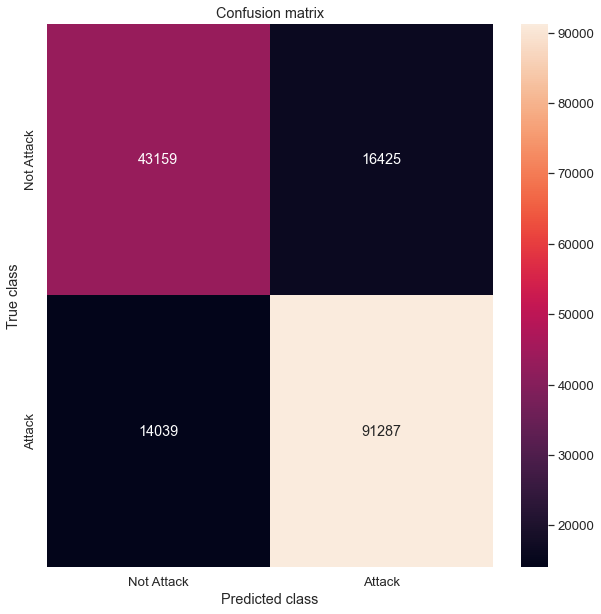

validation dataset



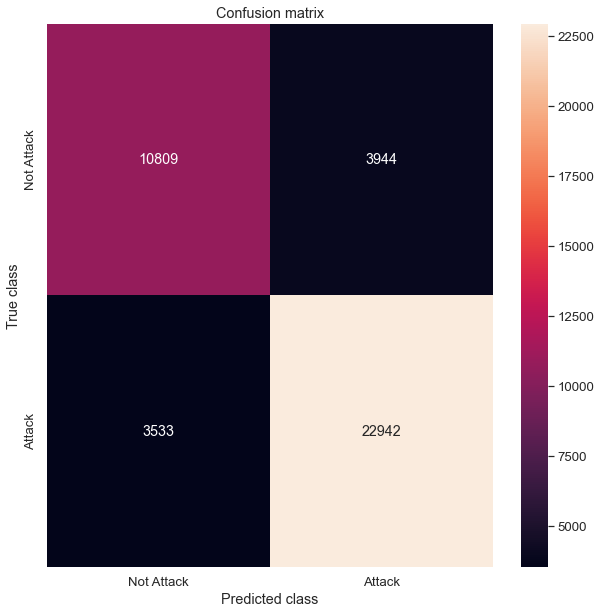

testing dataset



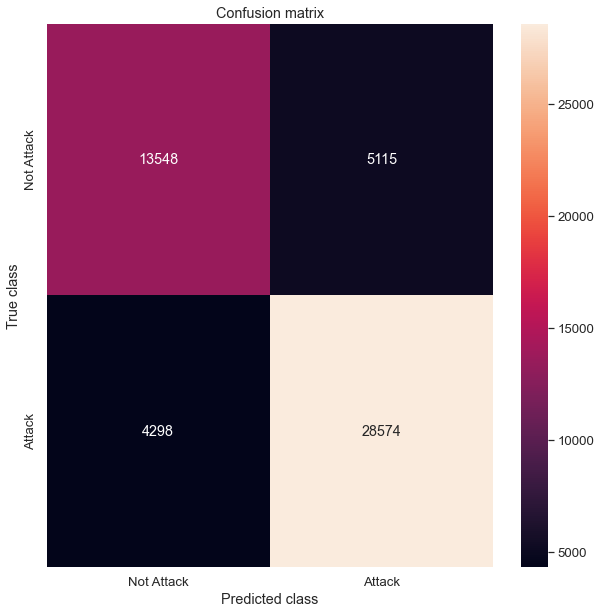

In [16]:
print('training dataset\n')
show_confusion_matrix(tr_df, tr_pred)
print('validation dataset\n')
show_confusion_matrix(val_df, val_pred)
print('testing dataset\n')
show_confusion_matrix(tt_df, tt_pred)